# Puerto Rico Mortality Rates After Hurricane María 

## Requirements:

__Tools:__ The project is done in python, using a number of useful open source python packages:
- __Numpy__ Python's scientific computing package. http://www.numpy.org/
- __Pandas__ A very useful data analysis and manipulation package http://pandas.pydata.org/
- __Matplotlib__ Package for creating charts and other visualizations https://matplotlib.org/
- __GGPlot__ Package for plotting http://ggplot.yhathq.com
- __PyPDF2__ Package that reads and extracts text from the pdfs https://pypi.org/project/PyPDF2/
- __Scikit-misc__ Package used for Loess smoothing https://pypi.org/project/scikit-misc/
    


## Overview: 

This noteboook is created by a team of students participating in the Data Science (CCOM4995033) course given at the Computer Science Department of the University of Puerto Rico, Río Piedras Campus. 
The team is made up of 5 members: Coralys Cubero Rivera, Eddie Pérez, Sebastián Cruz, Alexa Gonzalez and Jean Rivera. 
    
The purpose of this project is to replicate the work done by Dr. Rafael Irizarry, found at: https://simplystatistics.org/2018/06/08/a-first-look-at-recently-released-official-puerto-rico-death-count-data/, where he makes an estimation of the mortality rates in Puerto Rico after hurricane María made landfall in September of 2017.
        
The project is organized as follows:

**Step 1. Data Wrangling**

- We first extract and clean the data provided by the Puerto Rico Department of Health, which presents the monthly death count data for the time period after Hurricane María.

**Step 2. Plotting**

- We plot and analyze the raw data; looking to understand the patterns and clear effects in the population after the hurricane. 

**Step 3. Statistical Analysis**

- After plotting the data, the next step is to make sense of the data and do inferences about the excess of deaths after the event. 

**Step 4. Visualization**

-  To communicate information clearly and efficiently, we do data visualization using the adecuate graphs to represent the data.


(Clarification: Steps 3 and 4 are presented separately in the overview, but for the sake of simplicity are summarised as a single step in the actual work.)

## Estimating the mortality rates in Puerto Rico after Hurricane María

### Step 1: Data Wrangling

First, we import the neccesary packages to extract and clean the data. 




In [1]:
# importing required modules
import PyPDF2
import numpy as np
import re
import pandas as pd
import datetime
import matplotlib.dates as mdates #to handle time series
import matplotlib.pyplot as plt
from skmisc.loess import *
from ggplot import *


/anaconda3/lib/python3.7/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,


Then, we need to open and read the file that contains the data we are analyzing. 

In [2]:
pdfFileObj = open('RD-Mortality-Report_2015-18-180531.pdf', 'rb')
pdfReader = PyPDF2.PdfFileReader(pdfFileObj)

# Saving the number of pages in pdf file so that we can iterate over the pages
num_pages = pdfReader.numPages

# A
To do the data wrangling of the file provided by the Puerto Rico Department of Health, we created the dataWrangling function. Since the data is provided in a PDF file, there is a lot of extra information that we do not really need for our analysis. Therefore, we start our function by extracting the text and making an initial cleaning of the data.


# B
After organizing the values into an array, we need to further clean the data to take out the statistical values provided - such as totals, average values, maximums, and minimums - since we only want the raw data from each month and each year. Then, we also go ahead and organize the array into the rows of the tables, achieving a better structure for the data and making it easier to turn it into a dataframe later on. (B)

# C
After getting all the pages with the data organized into rows, we turn it into a numpy array and then turn it into a dataframe. When we turn it into a dataframe, we start manipulating it and changing it in order to make it as tidy and humanly readible as possible. At the end of our function, it returns a dataframe with 6 columns: month, day, 2015, 2016, 2017 and 2018.


In [3]:
###A
def dataWrangling(i):
    # We create an array that will contain all the pages found in the file, with the text already extracted.
    all_pages = []
    
    # Creating a page object
    pageObj = pdfReader.getPage(i)

    # Extracting the text from the current page
    page = pageObj.extractText()
    
    # The text is given to us in unicode, and so we turn it into a string. 
    #page = page.encode('utf-8') 
    
    # We start replacing the text we do not want either with blank spaces or with their number representations
    page = page.replace("6/4/2018\n", "")
    page = page.replace("JAN", "01")
    page = page.replace("FEB", "02")
    page = page.replace("MAR", "03")
    page = page.replace("APR", "04")
    page = page.replace("MAY", "05")
    page = page.replace("JUN", "06")
    page = page.replace("JUL", "07")
    page = page.replace("AGO", "08")
    page = page.replace("SEP", "09")
    page = page.replace("OCT", "10")
    page = page.replace("NOV", "11")
    page = page.replace("DEC", "12")
    
    # We use a regular expression to match every character that is non-digit and replace it with a blank space
    page = re.sub("\D", " ", page)
    page = re.sub("                                                                                      ", "", page)
    
    # After taking out the text and a huge space gap that results from the initial replacements,
    # we split the data from the page by blank spaces, creating a huge array. 
    page = page.split()
    
    # The tables are organized into rows of five columns and so that's how we split our array. 
    # However, if the program finds the total value of the table, which is higher than 2000 every time, then it breaks and it stops appending the data.

    ###B
    for j in range(5, len(page), 5):
            all_pages.append(page[(j-5):j])
            if (int(page[j]) >= 2000):
                break
    
    ###C
    # We build the numpy array that contains all of the pages inside the file. 
    all_pages = np.array(all_pages)
    
    # We then create a dataframe and rename the columns accordingly
    df = pd.DataFrame(all_pages, columns=['month', '2015', '2016', '2017', '2018'])
    df['day'] = df.index
    cols = ['month', 'day', '2015', '2016', '2017', '2018']
    df = df[cols]
    df['day'] = df.index
    month = int(df.iloc[0:1, 0])
    df['month'] = month
    df = df.drop(df.index[0])

    # Dealing with february
    k = 0
    if month == 2:
        k = int(df.iloc[28, [2]])
        df.iloc[28, 2:6] = 0
        df.iloc[28, 3] = k
    return df             

Once we have our function ready, we call it with the necessary parameter to iterate through every page of the file and build our dataframes. Then, we proceed to concatenate all of them and turn them into one big dataframe with all the data extracted from the file. Moreover, to further clean the data, we go ahead and melt our year columns.

In [4]:
x = []
for i in range(num_pages):
    x.append(dataWrangling(i))

df_of = pd.concat([x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9], x[10], x[11]])
df_off = pd.melt(df_of, id_vars=['month', 'day'], var_name='year', value_name='deaths')


# A
Since we want our data to be as tidy as it can be, we decide to take the "month", "day", and "year" columns and turn it into a single column that holds the representative full date.
# B
Finally, we rename the columns appropiately to "date" and "deaths" and we present the final result obtained from the data wrangling. This is now useful information that is appropiate for analysis.

In [5]:
###A
date_ymd = []
for i in range(len(list(df_off.index))):
    if (int(df_off.iloc[i, [0]]) == 2 and int(df_off.iloc[i, [1]]) == 29 and (int(df_off.iloc[i, [2]]) == 2015 or int(df_off.iloc[i, [2]]) == 2017 or int(df_off.iloc[i, [2]]) == 2018)):
            date_ymd.append(None)
            continue
    date_ymd.append(datetime.date(int(df_off.iloc[i, [2]]), int(df_off.iloc[i, [0]]), int(df_off.iloc[i, [1]])))

###B
df_off['date'] = date_ymd
df_official = df_off
cols = ['year', 'month', 'day', 'date', 'deaths']
df_official = df_official[cols]

print(df_official)

# Closing the pdf file object
pdfFileObj.close()

      year  month  day        date deaths
0     2015      1    1  2015-01-01    107
1     2015      1    2  2015-01-02    101
2     2015      1    3  2015-01-03     78
3     2015      1    4  2015-01-04    121
4     2015      1    5  2015-01-05     99
5     2015      1    6  2015-01-06    104
6     2015      1    7  2015-01-07     79
7     2015      1    8  2015-01-08     73
8     2015      1    9  2015-01-09     90
9     2015      1   10  2015-01-10     75
10    2015      1   11  2015-01-11     88
11    2015      1   12  2015-01-12     85
12    2015      1   13  2015-01-13     74
13    2015      1   14  2015-01-14     98
14    2015      1   15  2015-01-15     88
15    2015      1   16  2015-01-16    111
16    2015      1   17  2015-01-17     92
17    2015      1   18  2015-01-18     90
18    2015      1   19  2015-01-19    101
19    2015      1   20  2015-01-20     98
20    2015      1   21  2015-01-21    105
21    2015      1   22  2015-01-22     71
22    2015      1   23  2015-01-23

### Step 2: Plotting 

We assign the name of the variables to be use in the data frame for plotting. We change the values from strings to either numerics or datetimes to facilitate plotting and data manipulation.

In [6]:
#Step1: Changing the values in df_official from strings into either numerics or datetimes
df_official.year = pd.to_numeric(df_official.year)
df_official.month = pd.to_numeric(df_official.month)
df_official.day = pd.to_numeric(df_official.day)
df_official.deaths = pd.to_numeric(df_official.deaths)
df_official.date = pd.to_datetime(df_official.date)

Since the data from the pdf has only the deaths of the population before May 31,2018, we eliminate all data after that date so our estimations are not be affected by those 0 values.

In [7]:
#Step2: Eliminate zeroes
#Select only dates where deaths !=0: dates before 2018-05-31
df_official_noNaNs = df_official[df_official.date < pd.to_datetime(20180531,format='%Y%m%d')]
df_official_noNaNs = df_official_noNaNs[df_official_noNaNs.deaths != 0]

To understand better the raw data, we plot the population deaths by year from January,2015 up to March, 2018. We can see clearly that there is an increase of deaths after Hurricane Maria in 2017 compared to the same months the years before.

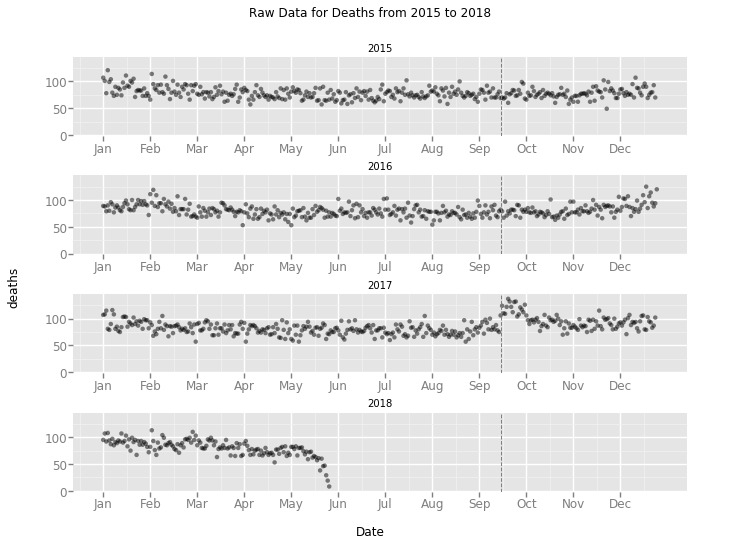

<ggplot: (-9223372029303688679)>


In [8]:
#Step3: Building aesthetics for the Raw Data plot
p = ggplot(aes(x='df_official_noNaNs.date.dt.dayofyear', y="deaths"), data=df_official_noNaNs)
p = p + geom_point(alpha = 0.5)
p = p + geom_vline(x=pd.to_datetime(20170920, format='%Y%m%d').dayofyear, linetype = 'dashed', color = 'grey')
p = p + ggtitle(title = 'Raw Data for Deaths from 2015 to 2018')
p = p + scale_x_continuous(name = 'Date',breaks = range(1,366,31), labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
p = p + facet_wrap('year', ncol=1)
print(p)

### Step 3 & 4: Statistical Analysis & Visualization


First step was to estimate the population from Puerto Rico. We took into consideration the emmigration that has been ocurring during the last years and the emmigration due to the hurricane. The data from emmigration due to the hurricane was obtained by human mobility trackers, Tetralytics. After obtaining this estimates we then interpolate for the missing data. So now, we have a daily rate estimate.

In [9]:
##Estimating deaths and population (interpolate) in the missing data
#Packages used statsmodels and matplotlib.pyplot

#Create a data.frame(df) with information to interpolate over
#df t is the real population data from the institute of statistics 
t = {'date':['2010-07-02','2011-07-02','2012-07-02','2013-07-02','2014-07-02','2015-07-02','2016-07-02','2017-07-02'],'pop':[3721525, 3678732, 3634488, 3593077, 3534874, 3473177, 3406520, 3337177]}
#df s is the estimated population calculated with the phone activity records from
#Teralytics. #We added or substracted to the population data from 2017-06-01 depending on phone activity to
#get our population estimates.
s = {'date':['2017-09-19','2017-10-15','2017-11-15','2017-12-15','2018-01-15','2018-02-15'],'pop':[3337000,3237000,3202000,3200000,3223000,3278000]}
t_df=pd.DataFrame(data=t)
s_df=pd.DataFrame(data=s)
#binding together both t and s data.frames (df)
tmp_df=pd.concat([t_df,s_df])
tmp_df = tmp_df.reset_index(drop=True)
#Changing the data type from sting to datetime and integer
tmp_df['date'] = pd.to_datetime(tmp_df['date'])
tmp_df['pop'] = pd.to_numeric(tmp_df['pop'], downcast = 'integer')
#Concatenating the tmp df and the official df to be able to interpolate over the missing values
t_df = pd.concat([df_official,tmp_df], keys = 'date')
t_df = t_df.reset_index(drop=True)
t_df = t_df.sort_values(by = 'date')
t_df = t_df.reset_index(drop=True)

#We only want to interpolate over populaion, we use date as the x axis.
t_df = t_df.iloc[0:1475,[0,4]] #We select only the date and pop columns

t_df_inter = t_df.interpolate(method='linear') #we do a linear interpolation

#Left join the estimated population to the official data.frame
df_official_interpolated = df_official.merge(t_df_inter, on = "date")
#Interpolation Success
##Calculating daily death rate estimate
df_official_interpolated = df_official_interpolated.assign(rate = df_official_interpolated['deaths']/df_official_interpolated['pop']*365*1000)


of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.
 [ipykernel_launcher.py:20]


After estimating the population daily death rate, we calculated the yearly death rate estimate. The death rate for 2018 was assumed the same as 2017 since the data was not provided. 

In [10]:
#We group by year and calculate the mean of all columns
df_official_summary = df_official_interpolated.groupby('year').mean()
#Rename the column 'rate' as 'year_rate'
df_official_summary['year_rate'] = df_official_summary['rate']

#keep only the 'year_rate column'
df_official_summary = df_official_summary.loc[:,'year_rate']

#Since we don't know the death rate of 2018 we assume it's the same as 2017
df_official_summary[2018] = df_official_summary[2017]

#Left join the 'year_estimate' into the official df
df_official_summary = df_official_summary.reset_index()

df_official_deathrate  = df_official_interpolated.merge(df_official_summary, on = 'year')

We calculate the median daily death rate with regards to the yearly rate, and then take the average of both to calculate an average death rate for the all years before 2017. These results are stored in a new data frame which will be used later on.

In [18]:
##Calculating the median daily rate of death in relationship to the yearly rate of death
##Before the hurricane
#We select only the dates before 2017 and that are not Feb 29
temp = df_official_deathrate[(df_official_deathrate['date'] < pd.to_datetime(2017, format = '%Y')) & (np.logical_not((df_official_deathrate['month']==2) & (df_official_deathrate['day']==29)))]

#We group by month and day to calculate the median daily rate in relation to the yearly rate
group = temp.groupby(['month', 'day'])['rate', 'year_rate'].apply(lambda x: (x.rate - x.year_rate).median())
#Result: A new df with the estimated daily rate of death for 2015-2016

avg_rate = group.reset_index().rename(columns = {0:'avg_rate'})
print(avg_rate)

     month  day  avg_rate
0        1    1  1.829299
1        1    2  1.467187
2        1    3 -0.197405
3        1    4  2.607763
4        1    5  0.941585
5        1    6  2.049685
6        1    7  0.546607
7        1    8 -0.558867
8        1    9  0.797839
9        1   10  0.235677
10       1   11  0.695843
11       1   12  0.276028
12       1   13 -0.398120
13       1   14  1.267933
14       1   15  1.123293
15       1   16  2.578743
16       1   17  1.225339
17       1   18  0.644697
18       1   19  1.108107
19       1   20  1.962700
20       1   21  1.316488
21       1   22 -0.123144
22       1   23  0.712193
23       1   24  1.241302
24       1   25  0.765272
25       1   26  1.084688
26       1   27  0.195864
27       1   28  1.293125
28       1   29  0.250229
29       1   30  0.403460
..     ...  ...       ...
335     12    2  0.946203
336     12    3 -0.399977
337     12    4 -0.069976
338     12    5 -0.330159
339     12    6  0.967409
340     12    7 -0.013497
341     12  

We next define a function for the Loess fit. This will produce an output of the predicted values as well as the confidence interval for the predictions. Essentially, we're using Loess to identify any underlying patterns in the data that can only be obtained by smoothing a regression curve. 

In [12]:
# Modified Helper function from the Scikit-misc github (https://github.com/has2k1/scikit-misc/blob/master/examples/loess-basic-usage.ipynb)
def loess_fit(x, y, span=0.75, degree=1):
    """
    loess fit and confidence intervals
    """
    # setup
    lo = loess(x, y, span=span, degree=degree)
    # fit
    lo.fit()
    # Predict
    prediction = lo.predict(x, stderror=True)
    # Compute confidence intervals
    ci = prediction.confidence(0.05)
    # Since we are wrapping the functionality in a function,
    # we need to make new arrays that are not tied to the
    # loess objects
    yfit = np.array(prediction.values)
    ymin = np.array(ci.lower)
    ymax = np.array(ci.upper)
    return yfit, ymin, ymax


Afterwards, the data we've already created is preprocessed so that we can apply the Loess function to it. Here the average death rate calculated two cells above is assigned to day, and then the dates are changed to the Month-Day-Year format.

In [13]:
#Preprocessing the data for the fit
day = avg_rate.assign(year = 1970).drop(columns = 'avg_rate')
day = pd.to_datetime(day, format='%m%d%Y')
day = pd.to_numeric(day.dt.dayofyear)
xx = day.append([day-365, day+365], ignore_index = True)
xx = xx.sort_values().reset_index(drop=True)

yy = pd.Series(np.tile(avg_rate['avg_rate'], 3))

The Loess function is then applied to the objects created above, and we obtain an output with the predicted values as well as confidence intervals for these predictions. The main takeaway here is tat we want to identify the deaths trend for each year, as we want to compare the rate for 2017 to the rate for all years before, and conclude if the death rate was abnormal for 2017.

In [14]:
#Carrying out the loess 
#Create loess objects
lo= loess(xx,yy, family = 'symmetric', span = 0.15, degree = 2)
lo.fit()
fit = pd.Series(lo.outputs.fitted_values)

#Add a column to the avg_rate df called 'trend', this will be the data of the fit
#The reason we add this column to the avg_rate df is to make use of the 'month' and 'day' columns
#This way it'll be easier to join this data with the official df
avg_rate['trend'] = pd.Series(fit) 
#We drop the 'avg_rate' column
trend = avg_rate.drop(columns = 'avg_rate')

#joining trend to df_official
df_official_trend0 = df_official_deathrate.merge(trend, on = ['month', 'day'])
df_official_trend = df_official_trend0.sort_values('date').reset_index(drop=True)

The results from the Loess fit are then plotted. Figure 1 shows that although Puerto Rico's population has been in steady decline (mass emigration and an aging population are the main culprits), there is a sharp decline near the end of 2017, which coincides with the period in which Hurricane María struck Puerto Rico. The trend continues into early 2018.

Figure 2 shows the trend for death rates for 2017. As we can clearly see, September (which is, again, the month in which Hurricane María struck the island) has an increase in death rates which continues to increase well into Winter. This indicates a period of immediate disaster, as well as a deadly aftermath.

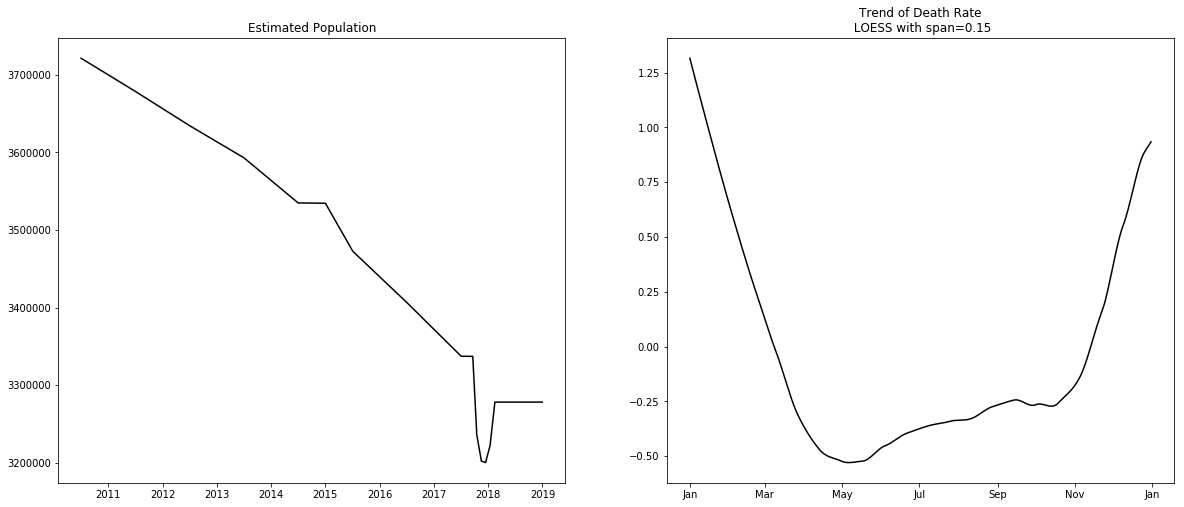

In [15]:
##Plotting the estimated population and the trend of death rate
temp = df_official_trend[(df_official_trend['date'] >= pd.to_datetime(2017, format = '%Y')) & (df_official_trend['date'] < pd.to_datetime(2018, format = '%Y'))]

fig1 = plt.figure(figsize=(20, 18))
#Figure 1: Estimated Population
ax1 = fig1.add_subplot(221)
ax1.plot('date', 'pop', color='black', data = t_df_inter)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.set_title('Estimated Population')

#Figure 2: Trend of Death Rate
ax1 = fig1.add_subplot(222)
ax1.plot('date', 'trend', color='black', data = temp)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax1.set_title("Trend of Death Rate\n LOESS with span=0.15")



#Show Figure
plt.show()
#Clear plot
plt.cla()
fig1.clf()
plt.close()

With all in place, we can now calculate a rate for the actual observed death rate versus what was expected. After calculating this, we plot the data. The x-axis shows months for 2017 and part of 2018, while the y-axis shows the actual observed death rate. The dashed line represents the expected death rate according to the rates from past years. Hence, we observe a significant increase on September 2017 which continues well into January 2018.

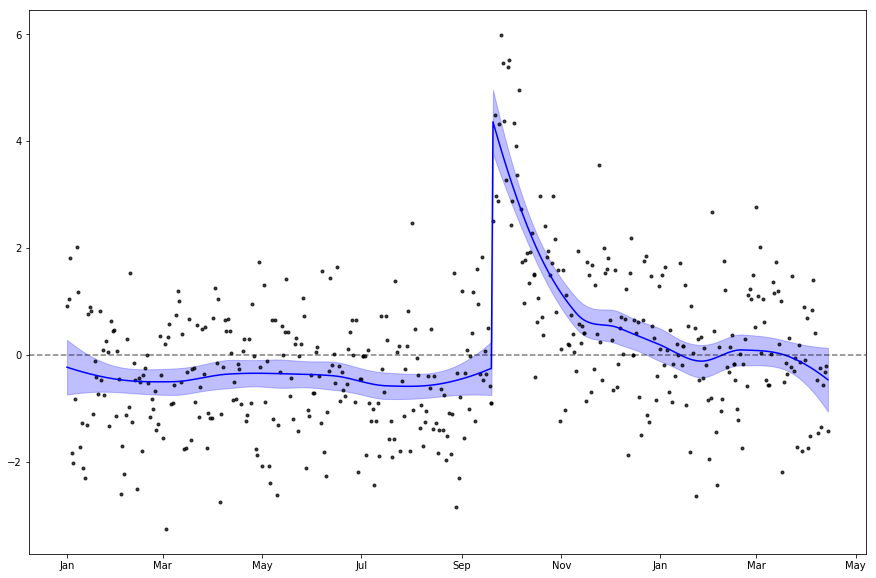

In [20]:
##LOESS for dates before the hurricane
#Select the dates before
temp1 = df_official_trend[(df_official_trend['date'] >= pd.to_datetime(2017, format = '%Y')) & (df_official_trend['date'] < pd.to_datetime(20170920, format = '%Y%m%d'))]

temp1 = temp1.assign(y = temp1['rate']-temp1['year_rate']-temp1['trend'], x = pd.to_timedelta(temp1['date']).dt.days)

before_smooth_fit, before_smooth_ymin, before_smooth_ymax =loess_fit(temp1['x'], temp1['y'], span=.66, degree = 2)

##LOESS for dates after the hurricane
#Selecting dates after 
temp2 = df_official_trend[(df_official_trend['date'] >= pd.to_datetime(20170920, format = '%Y%m%d')) & (df_official_trend['date'] < pd.to_datetime(20180415, format = '%Y%m%d'))]

temp2 = temp2.assign(y = temp2['rate']-temp2['year_rate']-temp2['trend'], x = pd.to_timedelta(temp2['date']).dt.days)

after_smooth_fit, after_smooth_ymin, after_smooth_ymax =loess_fit(temp2['x'], temp2['y'], span=.66, degree = 2)

#Joining before and after smooth, predicting standard error of the smooth
temp3 = df_official_trend[(df_official_trend['date'] >= pd.to_datetime(20170101, format = '%Y%m%d')) & (df_official_trend['date'] < pd.to_datetime(20180415, format = '%Y%m%d'))]
temp3 = temp3.reset_index(drop=True)
temp3 = temp3.assign(smooth = pd.concat([pd.Series(before_smooth_fit),pd.Series(after_smooth_fit)],ignore_index=True))
temp3 = temp3.assign(ymin = pd.concat([pd.Series(before_smooth_ymin),pd.Series(after_smooth_ymin)], ignore_index = True))
temp3 = temp3.assign(ymax = pd.concat([pd.Series(before_smooth_ymax),pd.Series(after_smooth_ymax)], ignore_index = True))
temp3 = temp3.assign(diff = temp3['rate']-temp3['year_rate']-temp3['trend'])
tmp = temp3
#Using the before smooth and after smooth, we create the visualization of the data. 
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
plt.plot('date', 'diff', '.',color = 'black', alpha = 0.75, data = temp3)
plt.plot(temp3.date, temp3.smooth, color = 'blue')
plt.fill_between(temp3.date.dt.to_pydatetime(), temp3.ymin, temp3.ymax, color='blue',alpha=.25)
plt.axhline(linestyle = '--', color = 'black', alpha = 0.5)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.show()
#Close figs
fig.clear()


Estimating  the count of excess death by dates. The dashed line shows us the 64 deaths count. This number was given by the government of Puerto Rico as the official death count shortly after hurricane María. It is evident that  64 deaths were reached during the first few days and that the deaths kept increasing months after. Deaths deep into March 2018 were approximately 1,400 in excess.

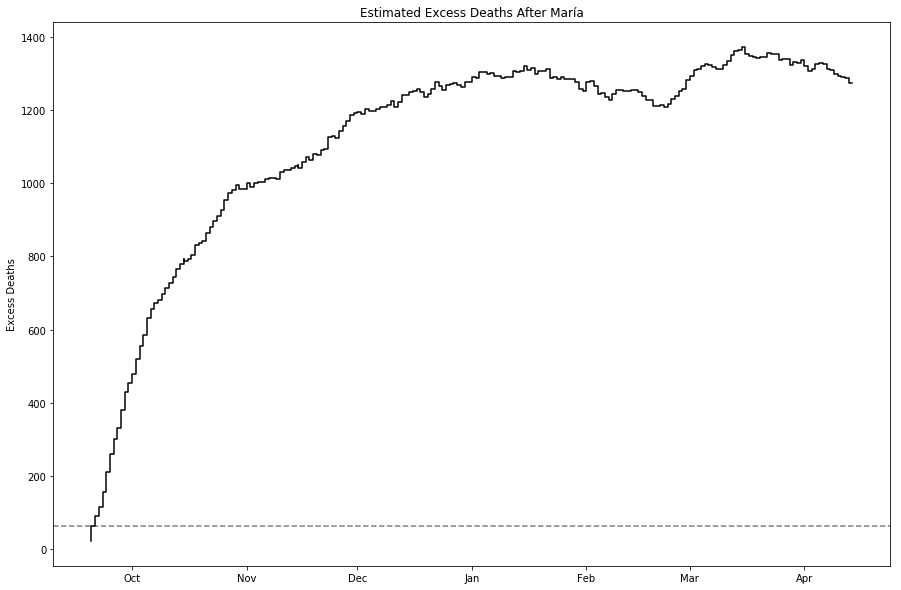

In [17]:
#Calculating Excess deaths by date
pop2017 = 3337177
temp = tmp[(tmp['date'] >= pd.to_datetime(20170920, format = '%Y%m%d'))]
temp = temp.assign(raw_cdf = np.cumsum(temp['diff']*pop2017/1000/365))
temp = temp.assign(smooth_cdf = np.cumsum(temp['smooth']*pop2017/1000/365))
#Plotting Excess deaths by date
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
plt.step(temp.date, temp.raw_cdf, color = 'black')
plt.axhline(64,linestyle = '--', color = 'black', alpha = 0.5)
plt.ylabel("Excess Deaths")
plt.title("Estimated Excess Deaths After María")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))